# B regressor final training

## Import

### Import modules

In [1]:
from __future__ import division ,print_function
import random
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K

import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../../modules')
from MPPlot import *
from Processors import *


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
loc = '../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['260', '270', '280', '300', '320', '400', '500', '550', '600' ,'700']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data X
    Returns: X after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)
    
    return X

data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


### Process data and add new features

In [3]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum


moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [4]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


### Specify variables

In [5]:

genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
print(*trainFeatures, sep=' , ')

t_0_pT , t_0_eta , t_0_phi , t_0_mass , t_1_pT , t_1_eta , t_1_phi , t_1_mass , b_0_pT , b_0_eta , b_0_phi , b_0_mass , b_0_csv , b_1_pT , b_1_eta , b_1_phi , b_1_mass , b_1_csv , mPT_pT , mPT_phi , h_tt_pT , h_tt_eta , h_tt_phi , h_tt_mass , h_tt_svFit_mass , h_bb_pT , h_bb_eta , h_bb_phi , h_bb_mass , diH_pT , diH_eta , diH_phi , diH_mass , diH_kinFit_mass , diH_kinFit_prob , mT , hT , sT , centrality , eVis , sphericity , spherocity , aplanarity , aplanority , upsilon , dShape , sphericityEigen0 , sphericityEigen1 , sphericityEigen2 , spherocityEigen0 , spherocityEigen1 , spherocityEigen2 , t_0_px , t_0_py , t_0_pz , t_0_|p| , t_0_E , t_1_px , t_1_py , t_1_pz , t_1_|p| , t_1_E , b_0_px , b_0_py , b_0_pz , b_0_|p| , b_0_E , b_1_px , b_1_py , b_1_pz , b_1_|p| , b_1_E , h_tt_px , h_tt_py , h_tt_pz , h_tt_|p| , h_tt_E , h_bb_px , h_bb_py , h_bb_pz , h_bb_|p| , h_bb_E , diH_px , diH_py , diH_pz , diH_|p| , diH_E , mPT_px , mPT_py , mPT_|p| , t_1_mT , hl_mT


In [6]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]

other = [var for var in trainFeatures for x in ['Fit', 'csv'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi+ other]
print(trainFeatures)

['t_0_mass', 't_1_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_mT']


In [7]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures ]

In [8]:
finalFeatures = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi] + ['hl_mT']

## Specify options

In [9]:
ganTrainFeatures = finalFeatures
normIn = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'


In [53]:
def getGenerator(nOut):
    classModel = Sequential()
    width = 100
    classModel.add(Dense(width, input_dim=1)) #First layer requires number of inputs
    classModel.add(Activation('selu'))  
    for i in range(depth): #Continue to add hidden layers
        classModel.add(Dense(width)) #Subsequent layers inherit input_dim from previous layer   
        classModel.add(Activation('selu'))       
    classModel.add(Dense(nOut, activation='linear')) #Final layer requires one output
    #classModel.compile(**compileArgs) #Compile the network graph to prepare it for use
    #classModel.summary()
    return classModel

def getDiscriminator(nIn):
    classModel = Sequential()
    depth = 3
    width = 100
    classModel.add(Dense(width, input_dim=nIn)) #First layer requires number of inputs
    classModel.add(Activation('selu'))
    for i in range(depth): #Continue to add hidden layers
        classModel.add(Dense(width)) #Subsequent layers inherit input_dim from previous layer 
        classModel.add(Activation('selu'))      
    classModel.add(Dense(1, activation='sigmoid')) #Final layer requires one output
    #classModel.summary()
    return classModel

def getDm(nIn):
    compileArgs = {'loss':'binary_crossentropy','optimizer':'adam'} #Loss function and optimiser for NN
    classModel = Sequential()
    classModel.add(getDiscriminator(nIn))
    classModel.compile(**compileArgs) #Compile the network graph to prepare it for use
    #classModel.summary()
    return classModel

def getAm(nIn,nOut):
    compileArgs = {'loss':'binary_crossentropy','optimizer':'adam'} #Loss function and optimiser for NN
    classModel = Sequential()
    classModel.add(getGenerator(nOut))
    classModel.add(getDiscriminator(nIn))
    classModel.compile(**compileArgs) #Compile the network graph to prepare it for use
    #classModel.summary()
    return classModel
    

### Preprocess data

In [11]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []


In [12]:
X_class = inputPipe.fit_transform(devData[finalFeatures].values.astype(theano.config.floatX))
Y_class = pandas.Series(np.ones(X_class.shape[0]))


### Train regressors
Train nSplit times to find best convergence

In [13]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [14]:
trainParams = {'batch_size' : 64, 'verbose' : 0}

In [ ]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
G = getGenerator(len(finalFeatures))

for i in range(400):   
    fakeData = []
    fakeInput = []
    for i in range(len(devData)):
        fakeInput.append(random.random())
    fakeData = G.predict(fakeInput)
    fakeData = pandas.DataFrame(data=fakeData,    # values
                 columns=finalFeatures)  # 1st row as the column names
    X_fake = inputPipe.fit_transform(fakeData.values.astype(theano.config.floatX))
    X_all = np.append(X_fake, X_class,axis = 0)
    y_class = Y_class.append(pandas.Series(np.zeros(X_fake.shape[0])), ignore_index = True)
    print(y_class)
    
    faketrain,faketest,ytrain,ytest    = train_test_split(fakeInput, Y_class, test_size=0.33, random_state=42) 
    Xtrain, Xtest, Ytrain,Ytest    = train_test_split(X_all, y_class, test_size=0.33, random_state=42)
    D = None # Clearing the NN
    D = getDm(len(finalFeatures))
    D.reset_states #Just checking
    trainingData = (Xtrain, Ytrain)
    lossHistory = LossHistory()
    earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    saveBest = ModelCheckpoint("train_weights/Dbest.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
    D.fit(Xtrain, Ytrain,
              validation_data = (Xtest, Ytest),
              callbacks = [earlyStop,saveBest, lossHistory],
              epochs = 5)
    histories.append(lossHistory.losses)
    D.load_weights("train_weights/Dbest.h5")
    results.append({})
    results[-1]['loss'] = D.evaluate(X_all[test], y_class[test], verbose=0)
    print ("Score is:", results[-1])
    D.save('train_weights/Dtrain_' + str(i-1) + '.h5')   
    A = getAm(len(finalFeatures),len(finalFeatures))
    A.fit(faketrain,ytrain , validation_data = (faketest, ytest),
              callbacks = [earlyStop,saveBest, lossHistory],
              epochs= 1)

        
with open('train_weights/resultsFile.pkl', 'wb') as fout: 
    pickle.dump(results, fout)
print ("Cross-validation took {:.3f}s ".format(time.time() - start))
X_reg = None
y_reg = None
train = None
test = None
D.summary()
D = None

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       1.0
9       1.0
10      1.0
11      1.0
12      1.0
13      1.0
14      1.0
15      1.0
16      1.0
17      1.0
18      1.0
19      1.0
20      1.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      1.0
28      1.0
29      1.0
       ... 
7826    0.0
7827    0.0
7828    0.0
7829    0.0
7830    0.0
7831    0.0
7832    0.0
7833    0.0
7834    0.0
7835    0.0
7836    0.0
7837    0.0
7838    0.0
7839    0.0
7840    0.0
7841    0.0
7842    0.0
7843    0.0
7844    0.0
7845    0.0
7846    0.0
7847    0.0
7848    0.0
7849    0.0
7850    0.0
7851    0.0
7852    0.0
7853    0.0
7854    0.0
7855    0.0
Length: 7856, dtype: float64


### Plot training histories

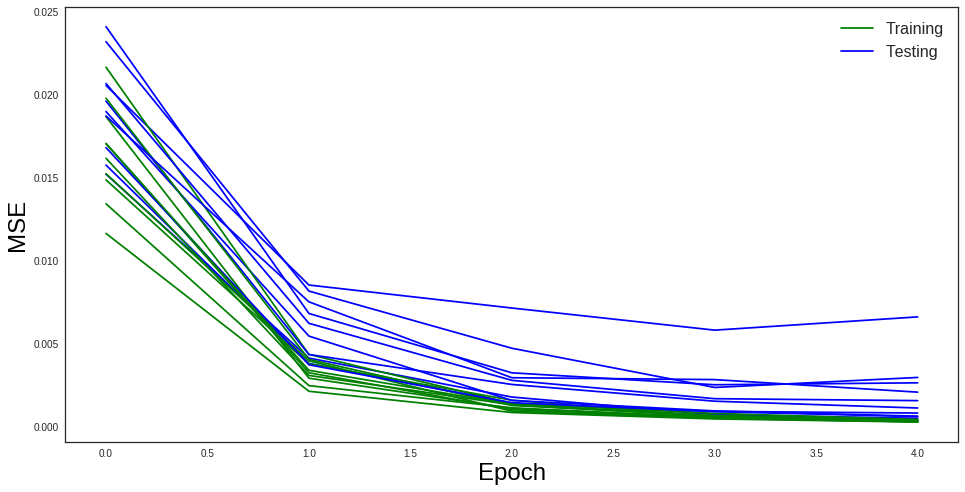

In [20]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

# Save

In [ ]:
name = "weights/NN_B_Regressor_App_" + mode + "_" 
print (name)

In [ ]:
# added 3 'b's (?) for some reason some need and other don't... don't get it
# i guess json as str and the others are bin

os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string) 
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'wb') as fout:
    pickle.dump(outputPipe, fout)

## Response of ensemble on development data

## Load

In [ ]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'rb') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'rb') as fin:
    outputPipe = pickle.load(fin)